In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 784])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 784])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

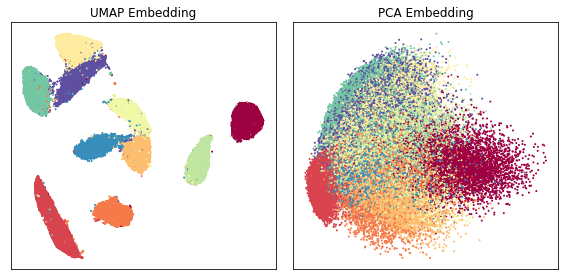

In [3]:
import os
import pickle
from umap import UMAP
from sklearn.decomposition import PCA


def create_embeddings(data, ignore_cache=False):
    umap_dir = "cache/umap.pickle"
    pca_dir = "cache/pca.pickle"

    if not os.path.isfile(umap_dir) or ignore_cache:
        umap_reducer = UMAP(random_state=42).fit(data)
        pickle.dump(umap_reducer, open(umap_dir, "wb"))
    else:
        umap_reducer = pickle.load(open(umap_dir, "rb"))

    if not os.path.isfile(pca_dir) or ignore_cache:
        pca_reducer = PCA(n_components=2, random_state=42).fit(data)
        pickle.dump(pca_reducer, open(pca_dir, "wb"))
    else:
        pca_reducer = pickle.load(open(pca_dir, "rb"))
        
    return umap_reducer, pca_reducer


umap_reducer, pca_reducer = create_embeddings(train_x, ignore_cache=False)
umap_data = umap_reducer.transform(train_x)
pca_data = pca_reducer.transform(train_x)

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].scatter(umap_data[:,0], umap_data[:,1], s=1, c=train_labels, cmap='Spectral')
axes[0].set_title("UMAP Embedding")

axes[1].scatter(pca_data[:,0], pca_data[:,1], s=1, c=train_labels, cmap='Spectral')
axes[1].set_title("PCA Embedding")
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

In [ ]:
import GK as gk


def plot_clusters(ax, data, centers):
    ax.scatter(data[:,0], data[:,1], s=1, c=train_labels, cmap='Spectral')
    ax.scatter(centers[:,0], centers[:,1], s=100, c="k", marker="^")


centers, memberships, u0, d, jm, p, fpc = gk.cmeans(
    train_x.T, 10, 1.1, 1e-8, 1000, seed=0)

umap_centers = umap_reducer.transform(centers)
pca_centers = pca_reducer.transform(centers)

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Clusters (UMAP)")
plot_clusters(axes[0], umap_data, np.zeros((10,2)))

axes[1].set_title("Clusters (PCA)")
plot_clusters(axes[1], pca_data, np.zeros((10,2)))

plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()